In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import os

In [ ]:
#specify the learning rate
learning_rate = 0.0005
#The learning rate has to do with the 
curr_dir = os.getcwd()
print(curr_dir)


# Load Dataset
df = pd.read_csv('BigData.csv')

#This portion of the code specifies the learning rate. 


In [ ]:
#Time Series Line Plot
df.plot(subplots=True, figsize=(12, 8), title="Feature Time Series")
plt.tight_layout()
plt.show()

#Correlation Heatmap
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()
##
#Boxplot for Identifying Outliers
for col in df.columns:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

C:\Users\nnaji\AppData\Local\Temp\ipykernel_5376\1723562491.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', num_features)  # 'tab20' provides up to 20 distinct colors


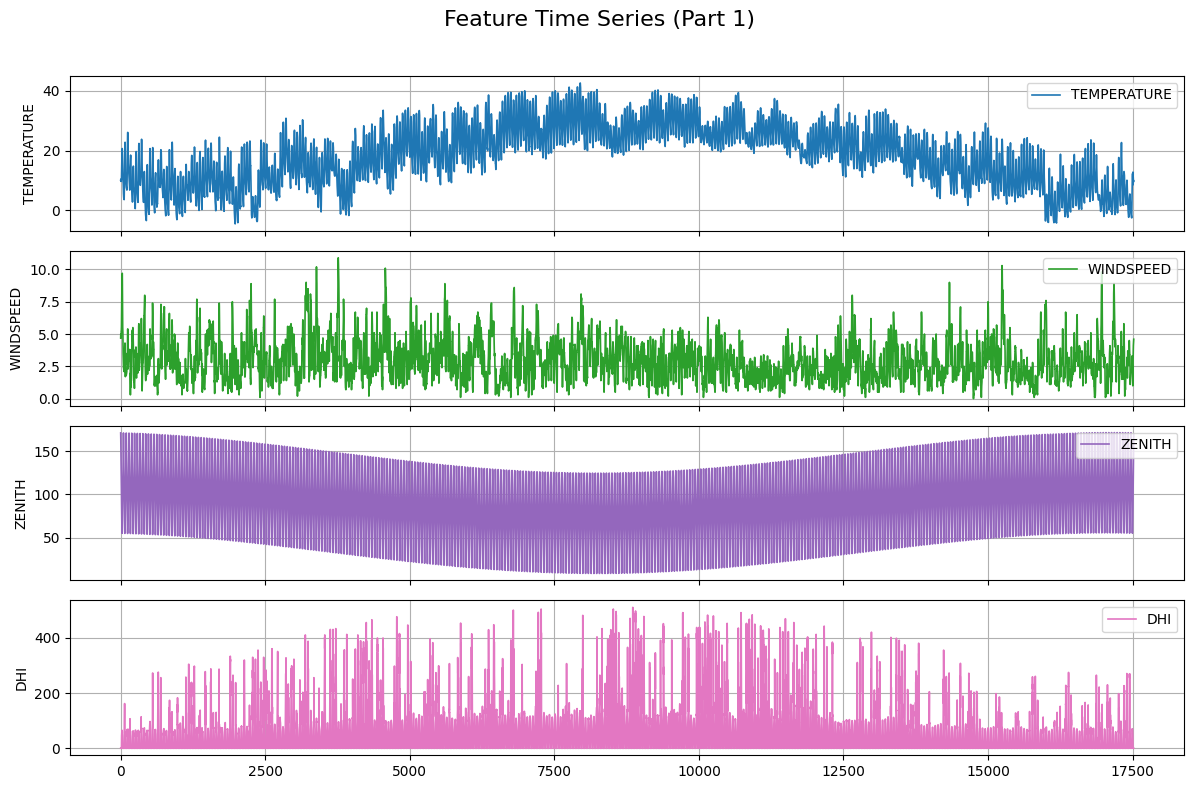

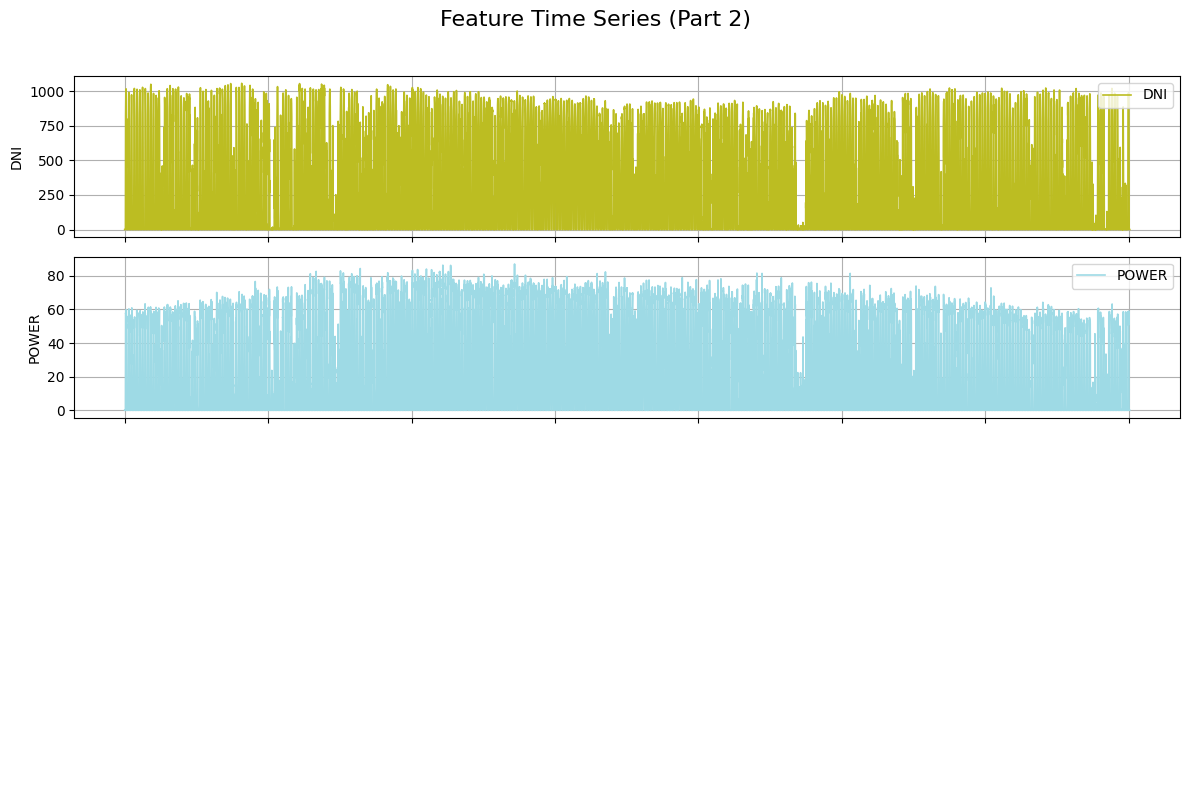

In [ ]:
#plotted the features to make sure there are not missing data points. 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Load your dataset
df = pd.read_csv('MedData.csv')  # or your actual filename

# Parameters
features_per_fig = 4
num_features = len(df.columns)
num_figs = (num_features + features_per_fig - 1) // features_per_fig

# Generate a color map
colors = cm.get_cmap('tab20', num_features)  # 'tab20' provides up to 20 distinct colors

# Plot
for i in range(num_figs):
    fig, axs = plt.subplots(features_per_fig, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f"Feature Time Series (Part {i+1})", fontsize=16)

    for j in range(features_per_fig):
        idx = i * features_per_fig + j
        if idx >= num_features:
            axs[j].axis('off')
            continue
        col = df.columns[idx]
        axs[j].plot(df[col], label=col, linewidth=1.2, color=colors(idx))
        axs[j].set_ylabel(col)
        axs[j].legend(loc='upper right')
        axs[j].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
# Separate Prediction Variable
solar_Xdata = df.copy()
solar_ydata = solar_Xdata.pop("POWER")
solar_Xdata = df.copy()

# Reshape Data
solar_Xdata = solar_Xdata.values.reshape(-1,solar_Xdata.shape[1])
solar_ydata = solar_ydata.values.reshape(-1,1)

In [ ]:
# Normalize Data
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

solar_XdataN = X_scaler.fit_transform(solar_Xdata)
solar_ydataN = y_scaler.fit_transform(solar_ydata)

In [ ]:
# Create Sequences
X, y = [], []
for i in range(24, len(solar_ydataN)):
    #This is the selected feautres that are going to be used. 
    y.append(solar_ydataN[i, 0])
X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(0.8 * len(y))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for LSTM layer
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))


In [ ]:
# Build LSTM Model
solar_model = Sequential()
solar_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
solar_model.add(LSTM(units = 50))
solar_model.add(Dense(units=1))

# Create Model
# set Epoch number
setEpoch = 50

# create the optimizer with the desired learning rate
adam_optimizer = Adam(lr = learning_rate)
solar_model.compile(optimizer=adam_optimizer, loss='mean_absolute_error')
solar_model.fit(X_train, y_train, epochs = setEpoch, batch_size = 32)

Epoch 1/50
438/438 [==============================] - 14s 21ms/step - loss: 0.1623
Epoch 2/50
438/438 [==============================] - 8s 18ms/step - loss: 0.1232
Epoch 3/50
438/438 [==============================] - 8s 19ms/step - loss: 0.1037
Epoch 4/50
438/438 [==============================] - 9s 21ms/step - loss: 0.0907
Epoch 5/50
438/438 [==============================] - 9s 20ms/step - loss: 0.0860
Epoch 6/50
438/438 [==============================] - 10s 22ms/step - loss: 0.0821
Epoch 7/50
438/438 [==============================] - 10s 22ms/step - loss: 0.0790
Epoch 8/50
438/438 [==============================] - 10s 23ms/step - loss: 0.0767
Epoch 9/50
438/438 [==============================] - 10s 23ms/step - loss: 0.0743
Epoch 10/50
438/438 [==============================] - 10s 24ms/step - loss: 0.0725
Epoch 11/50
438/438 [==============================] - 10s 23ms/step - loss: 0.0711
Epoch 12/50
438/438 [==============================] - 10s 22ms/step - loss: 0.0699
Epoch

In [ ]:
# Run Prediction
y_pred = solar_model.predict(X_test)
y_pred_orig = scaler.inverse_transform(y_pred)
y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1))

# Display / Graph
# Figure labels
fig, axs = plt.subplots()
fig.supxlabel("Time [3 days]")
fig.supylabel("DC Power [MW]")

In [ ]:
# Evaluate Error
mae = mean_absolute_error(y_test_orig, y_pred_orig)

# Display
axs.plot(y_test_orig[0:150])
axs.plot(y_pred_orig[0:150])

# Title Graph with Epochs and Error
title = "Train From " + str(solar_Xdata.shape[1]) + " Inputs\n" + "Epochs: " + str(setEpoch) + ". Avg MAE Error: " + str(f"{mae:.2f}")
fig.suptitle(title)

# Save Graph as PNG
filename = "Inputs_" + str(solar_Xdata.shape[1]) + "_Epochs_" + str(setEpoch)
filepath = 'Images/'
plt.savefig(curr_dir + "\\" +filename)
plt.show()